In [117]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  7 11:24:13 2024

@author: mrsag
"""

import yt
import numpy as np
import matplotlib.pyplot as plt
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from scipy.signal import fftconvolve
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.path import Path
from skimage import io
from skimage.transform import resize
from copy import deepcopy
from tqdm import tqdm

import matplotlib as mpl


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=100 # highres display

In [118]:

def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index

def moving_average(signal, window_size):
    # Define the window coefficients for the moving average
    window = np.ones(window_size) / float(window_size)
    
    # Apply the moving average filter using fftconvolve
    filtered_signal = fftconvolve(signal, window, mode='same')
    
    return filtered_signal

In [ ]:
class polygon_plate:
    def __init__(self, edges, potential=0, resolution=100):
        self.edges = edges  # List of (x, y) points
        self.potential = potential
        self.resolution = resolution
        self.mask = None

    def is_inside(self, x, y):
        # Ray casting algorithm for point-in-polygon
        n = len(self.edges)
        inside = False
        px, py = x, y
        for i in range(n):
            x0, y0 = self.edges[i]
            x1, y1 = self.edges[(i + 1) % n]
            if ((y0 > py) != (y1 > py)):
                x_intersect = (x1 - x0) * (py - y0) / (y1 - y0 + 1e-10) + x0
                if px < x_intersect:
                    inside = not inside
        return inside

    def generate_mask(self, xx, yy):
        mask = np.zeros_like(xx, dtype=bool)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                if self.is_inside(xx[i, j], yy[i, j]):
                    mask[i, j] = True
        self.mask = mask
        return mask


class Simulationbox2d:
    def __init__(self, resolution_x=300, resolution_y=300, box_x=1, box_y=1,
                 b_y0=0, b_x0=0, b_y1=0, b_x1=0,
                 potential_offset=0, match_boundary=True, potential_given_on_boundary=False):

        self.box_x = box_x
        self.box_y = box_y
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y

        self.yy, self.xx = np.mgrid[0:self.box_y:resolution_y*1j, 0:self.box_x:resolution_x*1j]
        self.potential = np.zeros_like(self.xx) + potential_offset

        def resample_boundary(boundary, target_length):
            if isinstance(boundary, (int, float)) and boundary == 0:
                return np.zeros(target_length)
            boundary = np.array(boundary)
            x_old = np.linspace(0, 1, len(boundary))
            x_new = np.linspace(0, 1, target_length)
            return np.interp(x_new, x_old, boundary)

        # Boundary setup
        self.b_y0 = resample_boundary(b_y0, resolution_x)  # bottom edge (y=0)
        self.b_y1 = resample_boundary(b_y1, resolution_x)  # top edge    (y=1)
        self.b_x0 = resample_boundary(b_x0, resolution_y)  # left edge   (x=0)

        delta_y0 = self.b_x0[0] - self.b_y0[0]
        delta_y1 = self.b_x0[-1] - self.b_y1[0]
        self.b_y0 += delta_y0
        self.b_y1 += delta_y1

        if match_boundary:
            self.b_x1 = np.linspace(self.b_y0[-1], self.b_y1[-1], resolution_y)
        else:
            self.b_x1 = resample_boundary(b_x1, resolution_y)

        # Apply boundary values
        self.potential[0, :] = self.b_y0         # y = 0 (bottom)
        self.potential[-1, :] = self.b_y1        # y = 1 (top)
        self.potential[:, 0] = self.b_x0         # x = 0 (left)
        self.potential[:, -1] = self.b_x1        # x = 1 (right)

        self.fixed_mask = np.zeros_like(self.potential, dtype=bool)
        if potential_given_on_boundary:
            self.fixed_mask[0, :] = True
            self.fixed_mask[-1, :] = True
            self.fixed_mask[:, 0] = True
            self.fixed_mask[:, -1] = True

    def add_polygon_plate(self, poly):
        mask = poly.generate_mask(self.xx, self.yy)
        self.potential[mask] = poly.potential
        self.fixed_mask[mask] = True


    def add_disk_plate(self, center, radius, potential=0):
        """
        Adds a circular plate (disk) to the simulation domain.

        Parameters:
        - center: (x, y) tuple for center of the disk
        - radius: radius of the disk (in simulation units)
        - potential: potential to assign to the disk
        """
        cx, cy = center
        distance = np.sqrt((self.xx - cx)**2 + (self.yy - cy)**2)
        mask = distance <= radius
        self.potential[mask] = potential
        self.fixed_mask[mask] = True


    def add_image(self, image, threshold=0.5, potential=0):
        """
        Adds a fixed potential region based on a grayscale image mask.

        Parameters:
        - image_path: path to the image file
        - threshold: normalized threshold (0–1) for deciding potential region
        - potential: potential value to assign above threshold
        """
        
        # Resize to match simulation resolution
        image=np.flip(image,axis=0)
        threshold /= np.max(image)
        resized_image = resize(image, (self.resolution_x, self.resolution_y), anti_aliasing=True)

        # Create mask where intensity > threshold
        mask = resized_image > threshold

        # Apply potential and fix those positions
        self.potential[mask] = potential
        self.fixed_mask[mask] = True

        
    def solve(self, max_iterations=10000, tolerance=1e-4):
        with tqdm(total=max_iterations, desc="Jacobi Iteration", colour='green', ncols=100, dynamic_ncols=False) as pbar:
            for it in range(max_iterations):
                potential_old = self.potential.copy()

                # Jacobi update
                self.potential[1:-1, 1:-1] = 0.25 * (
                    potential_old[1:-1, 2:] +
                    potential_old[1:-1, :-2] +
                    potential_old[2:, 1:-1] +
                    potential_old[:-2, 1:-1]
                )

                # Restore fixed values
                self.potential[self.fixed_mask] = potential_old[self.fixed_mask]

                # Check for convergence
                delta = np.abs(self.potential - potential_old).max()

                # Use tqdm.write to display iteration status without interrupting the bar
                # if it % 50 == 0:
                #     tqdm.write(f"Iteration {it}, max change: {delta:.2e}")

                # Update progress bar
                pbar.set_postfix_str(f"Δ={delta:.2e}")
                pbar.update(1)

                if delta < tolerance:
                    tqdm.write(f"Converged after {it} iterations")
                    break

            # Final message after the loop
            tqdm.write(f"final Max change in Itn({it+1}) - Itn({it}): {delta:.2e}")



Jacobi Iteration: 100%|██████████| 200/200 [00:00<00:00, 272.32it/s, Δ=8.92e-02]


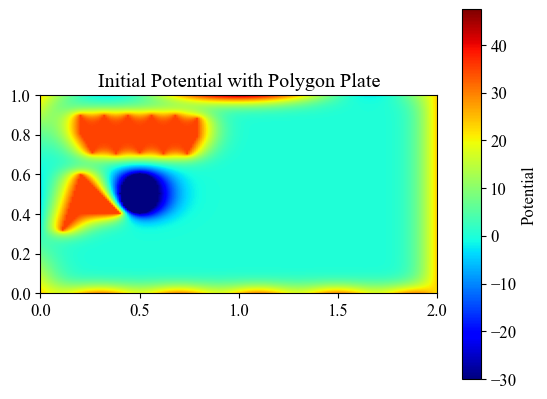

In [ ]:
plate1 = polygon_plate(
    edges=[(0.1, 0.3), (0.2, 0.6), (0.4, 0.4), (0.2, 0.4)],
    potential=35
)

# Create alternating zigzag points
x_plate2 = list(np.linspace(0.2, 0.8, 11))  # Use odd number for clean pairing
y_plate2 = 0.8*np.ones(len(x_plate2))
y_plate2[::2] +=0.1
x_plate2.extend(x_plate2[::-1])
y_plate2_bottom = list(y_plate2[::-1]-0.1)
y_plate2 = list(y_plate2)
y_plate2.extend(y_plate2_bottom)

# Top zigzag path
vertices_plate2 = [(x_plate2[i], y_plate2[i]) for i in range(len(x_plate2))]

# Now you can create the polygon plate
plate2 = polygon_plate(edges=vertices_plate2, potential=35)

b_y0 = -5*np.sin(np.linspace(0,31.4159,100))
b_x0 = 1*np.linspace(-5,5,100)**2-0.1*25
b_y1 = -25*np.sin(np.linspace(0,3*3.14159,100))

sim = Simulationbox2d(resolution_x=401, resolution_y=401, box_x=2, box_y=1,
                      b_y0=b_y0, b_x0 = b_x0, b_y1 = b_y1, 
                      match_boundary=True, potential_given_on_boundary=True)

sim.add_polygon_plate(plate1)
sim.add_polygon_plate(plate2)
sim.add_disk_plate(center=(0.5,0.5),radius=0.1,potential=-30)
sim.solve(max_iterations=500)

plt.imshow(sim.potential, origin='lower', cmap="jet",extent=[0,sim.box_x,0,sim.box_y])
plt.colorbar(label='Potential')
plt.title("Initial Potential with Polygon Plate")
plt.show()


Jacobi Iteration: 100%|██████████| 100/100 [00:00<00:00, 359.86it/s, Δ=1.17e-02]


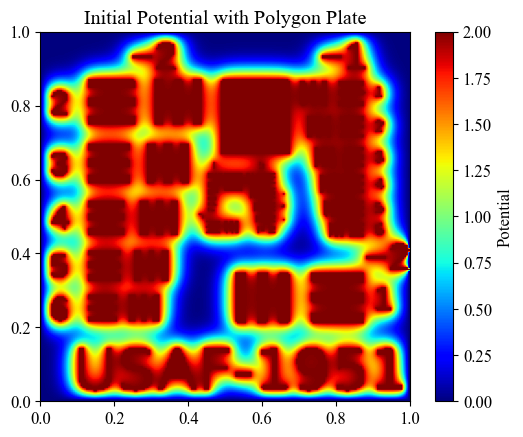

In [ ]:
# b_y0 = -5*np.sin(np.linspace(0,31.4159,100))
# b_x0 = 1*np.linspace(-5,5,100)**2-0.1*25
# b_y1 = -25*np.sin(np.linspace(0,3*3.14159,100))

image = io.imread(r"D:\temporary backup\Codes\lab codes\Diffraction pattern\USAF-1951.png")
image = image[:,:,1]

sim = Simulationbox2d(resolution_x=201, resolution_y=201, box_x=1, box_y=1,
                      potential_given_on_boundary=True)
sim.add_image(image,threshold=100,potential=2)
sim.solve(max_iterations=100)

plt.imshow(sim.potential, origin='lower', cmap="jet",extent=[0,sim.box_x,0,sim.box_y])
plt.colorbar(label='Potential')
plt.title("Initial Potential with Polygon Plate")
plt.show()


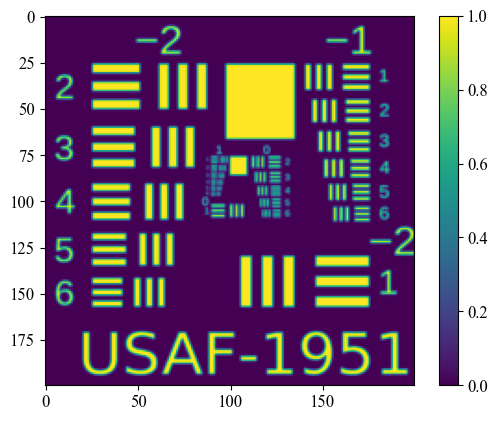

In [122]:
image = io.imread(r"D:\temporary backup\Codes\lab codes\Diffraction pattern\USAF-1951.png")
image = image[:,:,1]
image = resize(image,(200,200))

plt.imshow(image)
plt.colorbar()
plt.show()